In [1]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import seaborn as sns 
import re
import string
import nltk
from nltk.corpus import stopwords,wordnet
from bs4 import BeautifulSoup
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [3]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [4]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [5]:
clean_tweet=[]
for sentence in tqdm(train['tweet'].values):
    sentence=re.sub(r"http\S+", "",sentence)#remove url 
    sentence=re.sub("\S*@\S*\s?", "",sentence)#remove @ form the tweet
    sentence=BeautifulSoup(sentence,"lxml").get_text()#remove html tags
    sentence=re.sub("S*\d\S*","",sentence).strip()#remove numbers with words 
    sentence=re.sub("[^A-Za-z0-9]"," ",sentence)#remove punctuation
    sentence=" ".join(x.lower() for x in sentence.split() if x.lower() not in stopwords)
    sentence=" ".join(x.lower() for x in sentence.split() if len(x.lower())>2)
    clean_tweet.append(sentence.strip())

100%|██████████| 7920/7920 [00:04<00:00, 1898.44it/s]


In [6]:
clean_tweet_test=[]
for sentence in tqdm(test['tweet'].values):
    sentence=re.sub(r"http\S+", "",sentence)
    sentence=re.sub("\S*@\S*\s?", "",sentence)
    sentence=BeautifulSoup(sentence,"lxml").get_text()
    sentence=re.sub("S*\d\S*","",sentence).strip()
    sentence=re.sub("[^A-Za-z0-9]"," ",sentence)
    sentence=" ".join(x.lower() for x in sentence.split() if x.lower() not in stopwords)
    sentence=" ".join(x.lower() for x in sentence.split() if len(x.lower())>2)
    clean_tweet_test.append(sentence.strip())

100%|██████████| 1953/1953 [00:01<00:00, 1881.29it/s]


In [7]:
X=clean_tweet
y=np.array(train['label'])

In [8]:
Z=clean_tweet_test

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(ngram_range=(1,2),min_df=10)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
from sklearn import metrics

In [11]:
X_1,X_test,y_1,y_test=train_test_split(X,y,test_size=0.3,random_state=0)
X_train,X_cv,y_train,y_cv=train_test_split(X_1,y_1,test_size=0.3)

In [12]:
final_X_train=tfidf.fit_transform(X_train)
final_X_cv=tfidf.transform(X_cv)
final_X_test=tfidf.transform(X_test)

In [13]:
final_Z_test=tfidf.transform(Z)

In [14]:
final_Z_test

<1953x809 sparse matrix of type '<class 'numpy.float64'>'
	with 14476 stored elements in Compressed Sparse Row format>

In [15]:
from sklearn.naive_bayes import MultinomialNB

In [16]:
auc_cv=[]
auc_train=[]
alpha_values=[10**-5,10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4,10**5]
for i in alpha_values:
    mnb=MultinomialNB(alpha=i)
    mnb.fit(final_X_train,y_train)
    pred=mnb.predict_proba(final_X_cv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred))
    pred1=mnb.predict_proba(final_X_train)[:,1]
    auc_train.append(roc_auc_score(y_train,pred1))
    

In [17]:
auc_cv

[0.9238736396142058,
 0.9254566686287845,
 0.927914078290405,
 0.9308439201970499,
 0.9336975633544975,
 0.9353720308681132,
 0.9277083416675714,
 0.9019074451892872,
 0.8839835944092977,
 0.8800517389507051,
 0.8796021663304397]

In [18]:
optimal_alpha=alpha_values[auc_cv.index(max(auc_cv))]

In [19]:
optimal_alpha

1

In [20]:
import math

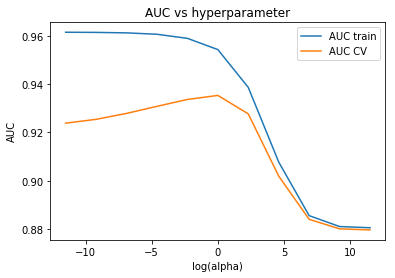

optimal alpha for which auc is maximum :  1


In [21]:
alpha_values=[math.log(x) for x in alpha_values]
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(alpha_values, auc_train, label='AUC train')
ax.plot(alpha_values, auc_cv, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('log(alpha)')
plt.ylabel('AUC')
ax.legend()
plt.show()
print('optimal alpha for which auc is maximum : ',optimal_alpha)

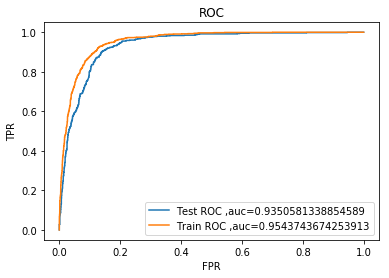

In [22]:
mnb=MultinomialNB(alpha = 1)
mnb.fit(final_X_train,y_train)
predi=mnb.predict_proba(final_X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred=mnb.predict_proba(final_X_train)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix
mnb=MultinomialNB(alpha=1)
mnb.fit(final_X_train,y_train)
predic=mnb.predict(final_X_test)

In [24]:
cm=confusion_matrix(y_test,predic)
cm

array([[1625,  147],
       [ 167,  437]], dtype=int64)

In [25]:
acc=accuracy_score(y_test,predic)*100
acc

86.78451178451179

In [26]:
predic1=mnb.predict(final_Z_test)

In [27]:
predic1

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

In [28]:
test['label']=predic1

In [29]:
test.head()

,id,tweet,label
0,7921,I hate the new #iphone upgrade. Won't let me d...,1
1,7922,currently shitting my fucking pants. #apple #i...,1
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t...",0
3,7924,My ipod is officially dead. I lost all my pict...,1
4,7925,Been fighting iTunes all night! I only want th...,1


In [30]:
final_test=test.drop('tweet',axis=1)

In [31]:
final_test

,id,label
0,7921,1
1,7922,1
2,7923,0
3,7924,1
4,7925,1
5,7926,0
6,7927,1
7,7928,0
8,7929,1
9,7930,0


In [33]:
final_test.to_csv('NBsol1.csv',index=False)

# Using NaiveBayes

In [ ]:
from sklearn.naive_bayes import 